<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/TrainNumSubjectsClassifier_02_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# df_annotations = pd.read_csv("all_annotations.csv")


# Get data

In [3]:
# with open("protocols.pkl.gz", "rb") as f:
#     file_to_pages = pkl.load(f)

In [4]:
# import spacy
# nlp = spacy.blank("en")

In [5]:
# texts = []

# for i in range(len(df_annotations)):
#     file_name = df_annotations.file.iloc[i]
    
#     pages= file_to_pages[file_name]
    
#     text = ""
#     for page in pages:
#         doc = nlp(page)
        
#         is_include = [False] * len(doc)
#         for tok in doc:
#             if tok.text.lower() in {"phase"}:
#                 for token_index in range(tok.i - 20, tok.i + 20):
#                     if token_index >= 0 and token_index < len(doc):
#                         is_include[token_index] = True
        
#         for token_index in range(len(doc)):
#             if is_include[token_index]:
#                 text += doc[token_index].text + doc[token_index].whitespace_
                
                
#     if text == "":
#         print ("nothing found", file_name, df_annotations.phase.iloc[i])
#         text = " ".join(pages)
#         if len(text) > 100000:
#             text = text[:100000]
#     else:
#         print ("found", file_name, df_annotations.phase.iloc[i])

#     texts.append(text)
# df_annotations["text"] = texts

In [6]:
# df_annotations.to_csv("filtered_for_phase.csv.bz2")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects.csv.bz2")

In [13]:
df_annotations.text = df_annotations.text.apply(lambda t : t[:10000] if len(t) > 10000 else t)

Override the subjects column with more up to date data

In [14]:
annots_with_subject = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")

In [15]:
(~df_annotations.num_subjects.isna()).sum(), (~annots_with_subject.num_subjects.isna()).sum()

(418, 11920)

In [16]:
df_annotations["num_subjects"] = annots_with_subject["num_subjects"]

In [17]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [18]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [19]:
# df_annotations = pd.read_csv("filtered_for_phase.csv.bz2")

In [20]:
# del file_to_pages

In [21]:
phase_map = {"Phase 2":"2",
"Phase 3":"3",
"Phase 4":"4",
"Phase 1":"1",
"Phase 1/Phase 2":"1.5",
"Not Applicable":"0",
"Phase 2/Phase 3":"2.5",
"Early Phase 1":"0.5"}
df_annotations["phase_clean"] = df_annotations["phase"].apply(lambda x : phase_map.get(x, None))

In [22]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 5:
        num = 5
    return num
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

# Begin Keras/TF

In [23]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [24]:
num_subjects_clean_map = {}
for idx, val in enumerate(sorted(set(df_annotations[~df_annotations.num_subjects_clean.isna()].num_subjects_clean), key = lambda x : int(re.sub(r'\D.*$', '', x)))):
  num_subjects_clean_map[val] = idx

In [58]:
# invert the dictionary
num_subjects_lookup = {v: k for k, v in num_subjects_clean_map.items()}

In [74]:
num_subjects_list = [num_subjects_lookup[x] for x in sorted(num_subjects_lookup)]
num_subjects_list

['1-24', '25+', '50+', '100+', '200+', '500+', '1000+', '10000+']

In [25]:
num_subjects_clean_map

{'1-24': 0,
 '25+': 1,
 '50+': 2,
 '100+': 3,
 '200+': 4,
 '500+': 5,
 '1000+': 6,
 '10000+': 7}

In [26]:
def get_one_hot_num_subjects(x):
  a = [0] * len(num_subjects_clean_map)
  if x is None:
    return a
  a[num_subjects_clean_map[x]] = 1
  return a

In [27]:
df_annotations["num_subjects_one_hot"] = df_annotations["num_subjects_clean"].apply(get_one_hot_num_subjects)

In [28]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [29]:
train_labels = np.asarray(list(df_train[~df_train.num_subjects_clean.isna()].num_subjects_one_hot))
test_labels = np.asarray(list(df_val.num_subjects_one_hot))

In [30]:
train_examples = np.asarray(list(df_train[~df_train.num_subjects_clean.isna()].text))
test_examples = np.asarray(list(df_val.text))

In [31]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 9535, test entries: 1085


In [32]:
train_examples[:10]

array(['SLC/F:/BABY-HUG/BHUG Protocol/August-09/B-CoverPageOnly.wpd —  8/09\n\nPEDIATRIC HYDROXYUREA PHASE III CLINICAL TRIAL\nBABY HUG\n\nPROTOCOL\n\nAugust 2009\n\n.\n\nPrepared by:\n\nClinical -1  Projected Enrollment, Maintenance of Assigned \n      Study Treatment 2-10\n\n3 PATIENT ELIGIBILITY, RECRUITMENT, ORIENTATION, \nAND INFORMED CONSENT\n3.1 Introduction 3-1  \n\n3.2 Inclusion and Exclusion Criteria 3.2.1 Inclusion Criteria 3-2  \n\n3.2.2 Exclusion Criteria for Pilot and Main Study 3-3  \n\n3.3 Recruitment 3-4  \n\n3.4 Parent/Guardian Orientation 3-5  \n\n3.5 Baseline Assessment 3-6 4-17\n\n4.4.1 Feasibility and Safety Pilot Study 4-17\n\n4.4.2 Primary Treatment Comparison (Full Phase III Trial) 4-17\n\n4.4.3 Spleen Endpoint 4-19\n\nTable 4-4 Power Classification and \nReporting of Adverse Events 4-34\n\nFigure 4-1 Absolute Effect Size\n\nTwo Sample Proportions 4-35\n\nFigure 4-2 Overlay of the Entry and Exit PK Studies \non \n\n8.3 Prophylactic Medications 8-3\n\n8.4 Parent

In [33]:
train_labels[:10]

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]])

In [34]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 2.25559   , -0.04003555,  0.93899107,  0.2506811 ,  0.84559846,
        -0.998915  , -1.1229645 ,  1.0880628 , -0.3572988 ,  0.24719179,
        -0.8556173 , -0.44134468,  0.5519561 , -1.7939239 ,  0.66371584,
        -0.8935602 ,  1.8869379 , -0.84141505,  0.69978   ,  1.0125706 ,
         0.08160346,  1.1788766 ,  1.5604182 , -0.34575224,  0.2779351 ,
        -1.3876771 ,  0.16311622,  1.9580957 , -1.0933205 , -1.0580326 ,
         0.37967965,  1.156498  , -0.72321945, -0.772455  ,  0.73082954,
        -0.9501583 ,  1.0493797 , -0.55693537, -0.37929386,  0.17795539,
        -0.31323153, -0.7816628 , -0.04035624,  1.1845489 ,  0.09255461,
        -0.6382013 ,  0.33023688, -0.7802934 , -0.03285996,  1.088984  ],
       [ 2.731097  , -0.18215285,  0.9739955 ,  0.586558  ,  0.60148025,
        -0.990663  , -0.7144665 ,  0.47427112, -0.06968777, -0.07448192,
        -0.7558011 ,  0.10947579,  0.10275193, -1.1342437 ,  0.38744602,
 

In [39]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
Total params: 48,191,552
Trainable params: 48,191,552
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.metrics.CategoricalAccuracy(name='accuracy')],
              run_eagerly=True)

In [41]:
# x_val = train_examples[:10000]
# partial_x_train = train_examples[10000:]

# y_val = train_labels[:10000]
# partial_y_train = train_labels[10000:]

partial_x_train = train_examples
x_val = test_examples

partial_y_train = train_labels
y_val = test_labels

In [76]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0848 - accuracy: 0.9956 - val_loss: 2.4383 - val_accuracy: 0.3309
Epoch 2/100
19/19 [==============================] - 2s 96ms/step - loss: 0.0765 - accuracy: 0.9948 - val_loss: 2.4736 - val_accuracy: 0.3235
Epoch 3/100
19/19 [==============================] - 2s 96ms/step - loss: 0.0692 - accuracy: 0.9959 - val_loss: 2.5100 - val_accuracy: 0.3327
Epoch 4/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0627 - accuracy: 0.9966 - val_loss: 2.5495 - val_accuracy: 0.3272
Epoch 5/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0581 - accuracy: 0.9964 - val_loss: 2.5788 - val_accuracy: 0.3244
Epoch 6/100
19/19 [==============================] - 2s 97ms/step - loss: 0.0531 - accuracy: 0.9973 - val_loss: 2.6110 - val_accuracy: 0.3253
Epoch 7/100
19/19 [==============================] - 2s 97ms/step - loss: 0.0487 - accuracy: 0.9977 - val_loss: 2.6384 - val_accuracy: 0.3263
Epoch 

In [77]:
model.save('num_subjects_model_02_keras.keras')

In [78]:
from google.colab import drive
drive.mount('/content/drive')
model.save("num_subjects_model_02_keras.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
results = model.evaluate(test_examples, test_labels)

print(results)

34/34 [==============================] - 1s 16ms/step - loss: 4.0081 - accuracy: 0.3088
[4.008062362670898, 0.3087557554244995]


In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

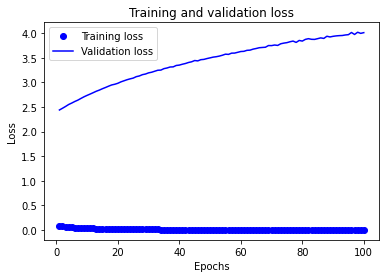

In [81]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

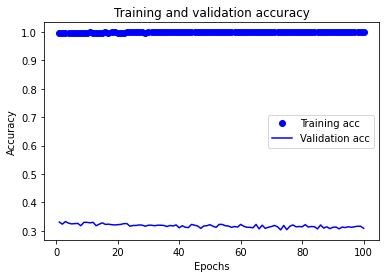

In [82]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [83]:
input_texts= np.asarray(df_val.text)

In [84]:
pred_proba = model.predict(input_texts)

34/34 [==============================] - 0s 9ms/step


In [85]:
df_val["y_pred_num_subjects"] = [num_subjects_lookup[one_hot] for one_hot in np.argmax(pred_proba, axis=1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
df_val["y_pred_num_subjects"].value_counts()

1-24      272
50+       209
25+       204
200+      153
100+      138
500+       71
1000+      33
10000+      5
Name: y_pred_num_subjects, dtype: int64

In [87]:
acc = accuracy_score(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
print (f"Subjects accuracy {acc}")

Subjects accuracy 0.3087557603686636


''

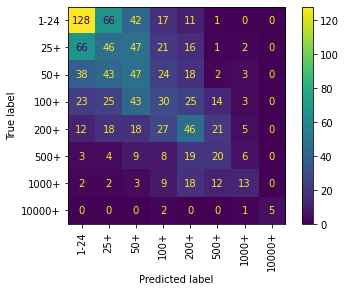

In [88]:
ConfusionMatrixDisplay.from_predictions(df_val.num_subjects_clean, df_val["y_pred_num_subjects"], labels=num_subjects_list)
plt.xticks(rotation=90)
;

In [89]:
num_correct = 0
for idx in range(len(df_val)):
  gt = num_subjects_clean_map[df_val["num_subjects_clean"].iloc[idx]]
  pred = num_subjects_clean_map[df_val["y_pred_num_subjects"].iloc[idx]]
  is_correct = int(np.abs(gt - pred) <= 1)
  num_correct += is_correct
print ("Accuracy including adjacent groups", num_correct/len(df_val))

Accuracy including adjacent groups 0.6774193548387096
